In [1]:
#meta 3/6/2021 my Numerai with Linear Regression

#history
#here 3/6/2021 SIMPLE LINEAR REGRESSION
#     Figure out Numerai training flow.
#     Not submitting - not sufficient modeling effort, i.e. no per era considerations


In [2]:
import time #to track performance time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.linear_model
import numerapi

# Numerai
Objective:  build a model to predict the future target using live features that correspond to the current stock market.

## 0. Load Data

### Datasets 
*   `training_data` is used to train your model
*   `tournament_data` is used to evaluate your model

### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance

In [3]:
# download the latest training dataset (takes around 30s), contains features and targets
#training_data = pd.read_csv("numerai_training_data.csv").set_index("id")
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
print(training_data.shape)
training_data.head()

(501808, 314)


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [4]:
# download the latest tournament dataset (takes around 30s)
#tournament_data = pd.read_csv("numerai_tournament_data.csv").set_index("id")
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
print(tournament_data.shape)
tournament_data.head()

(1665898, 314)


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [5]:
training_data.data_type.unique(), tournament_data.data_type.unique()

(array(['train'], dtype=object),
 array(['validation', 'test', 'live'], dtype=object))

#### Missing Targets
Train has none, Tournament many are missing - none missing in Valid, all missing in Test and Live.

In [6]:
#check nulls
(training_data['target'].isnull().sum(), training_data['target'].notnull().sum()), (tournament_data['target'].isnull().sum(), tournament_data['target'].notnull().sum())

((0, 501808), (1528119, 137779))

In [7]:
print(tournament_data['target'].unique())
tournament_data['target'].value_counts(dropna=False)

[0.25 0.5  1.   0.75 0.    nan]


NaN     1528119
0.50      68954
0.75      27533
0.25      27531
1.00       6882
0.00       6879
Name: target, dtype: int64

## 1. Data Prep

In [8]:
#split into datasets
valid_idx = tournament_data.index[tournament_data.data_type=='validation'].tolist()
test_idx = tournament_data.index[tournament_data.data_type=='test'].tolist()
live_idx = tournament_data.index[tournament_data.data_type=='live'].tolist()

df_valid = tournament_data.iloc[valid_idx]
df_test = tournament_data.iloc[test_idx]
df_live = tournament_data.iloc[live_idx]

X&y

The features are divided into 6 groups:
intelligence, wisdom, charisma, dexterity, strength and constitution. 

In [9]:
# define the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]

X_train = training_data[feature_cols]
y_train = training_data['target']
X_valid = df_valid[feature_cols]
y_valid = df_valid['target']
X_test = df_test[feature_cols]
y_test = df_test['target']
X_live = df_live[feature_cols]
y_live = df_live['target']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape, X_live.shape, y_live.shape

((501808, 310),
 (501808,),
 (137779, 310),
 (137779,),
 (1522723, 310),
 (1522723,),
 (5396, 310),
 (5396,))

#### Confirm Missing Targets
Train and Valid none are missing, Test and live all are missing.

In [10]:
#check nulls - numbers must match
(y_train.isnull().sum(), y_train.notnull().sum()), (y_valid.isnull().sum(), y_valid.notnull().sum()), (y_test.isnull().sum(), y_test.notnull().sum()), (y_live.isnull().sum(), y_live.notnull().sum())

((0, 501808), (0, 137779), (1522723, 0), (5396, 0))

## 2. Model

In [11]:
#track time
t0 = time.time()

# train a model to make predictions on tournament data
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print ("Training time (in min)", (time.time() - t0)/60)

Training time (in min) 0.16027798255284628


## 3. Evaluate Model

In [12]:
#predictions
predictions = model.predict(X_valid)
y_hat = pd.Series(predictions)
y_hat.head()

0    0.481608
1    0.492837
2    0.530817
3    0.497083
4    0.503089
dtype: float64

In [13]:
#evaluate predictions
n_valid = y_valid.shape[0]
loss = y_valid - y_hat

In [34]:
#calculate mse, rmse
mse = (loss**2).sum() / n_valid
rmse = np.sqrt(mse)
mse, rmse

(0.020351642612064545, 0.142659183413002)

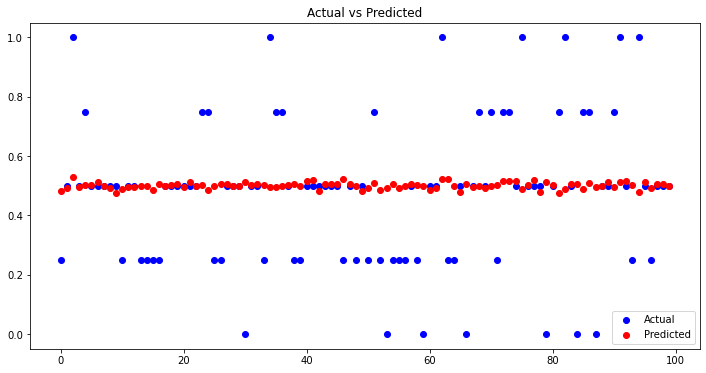

In [32]:
#preview first 100 stocks
plt.figure(figsize=(12,6))
plt.title("Actual vs Predicted")

plt.scatter(np.arange(100), y_valid[:100], color='b', label='Actual')
plt.scatter(np.arange(100), y_hat[:100], color='r', label='Predicted')
plt.legend(loc='lower right')

plt.show()

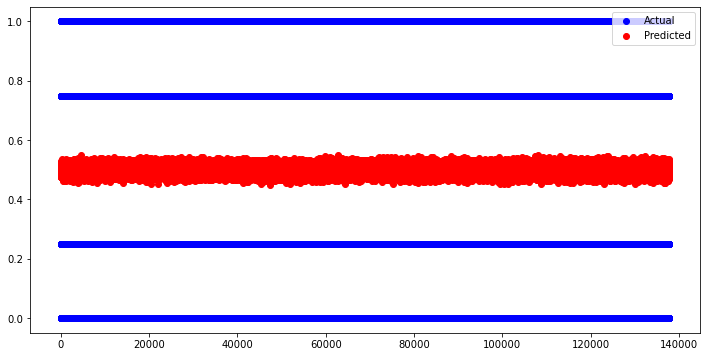

In [33]:
#view all
plt.figure(figsize=(12,6))

plt.scatter(np.arange(n_valid), y_valid, color='blue', label='Actual')
plt.scatter(np.arange(n_valid), y_hat, color='red', label='Predicted')
plt.legend(loc='upper right')

plt.show()

Note: no per era considerations during training.  Maybe that's why predictions look awful.

## Submit
still to do this part - not submitting because didn't do per era modeling

In [35]:
mystop

NameError: name 'mystop' is not defined

In [ ]:
# submit predictions to numer.ai
predictions = model.predict(tournament_data[feature_cols])
predictions

In [ ]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = tournament_data["id"].to_frame()
predictions_df["prediction"] = predictions
predictions_df.head()

In [ ]:
predictions_df.to_csv("output/predictions.csv")

In [ ]:
# Get your API keys and model_id from https://numer.ai/submit
public_id = "REPLACEME"
secret_key = "REPLACEME"
model_id = "REPLACEME"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)